# Bus Ticket Price Prediction - Production Pipeline

**Project:** ML-based price prediction for bus tickets  
**Framework:** scikit-learn 1.4.2, XGBoost with Weights & Biases monitoring

---

## Pipeline Overview

1. Data Ingestion & Validation
2. Exploratory Data Analysis
3. Data Preprocessing & Cleaning
4. Feature Engineering (24+ features)
5. Model Training (Multiple algorithms)
6. Model Evaluation & Selection
7. Model Persistence
8. W&B Dashboard Integration

## Section 1: Environment Setup

In [14]:
%%capture
# Install required packages with specific versions
!pip install -U pandas numpy scikit-learn==1.4.2 xgboost wandb python-dateutil joblib seaborn matplotlib



In [15]:
# Core libraries
import pandas as pd
import numpy as np
import json
import warnings
from datetime import datetime, timedelta
from dateutil import parser as date_parser
import logging

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import joblib
import pickle

# Weights & Biases
import wandb

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment setup complete.")
print(f"Python Libraries Loaded:")
print(f"  - pandas: {pd.__version__}")
print(f"  - numpy: {np.__version__}")
import sklearn
print(f"  - scikit-learn: {sklearn.__version__}")
print(f"  - xgboost: {xgb.__version__}")

Environment setup complete.
Python Libraries Loaded:
  - pandas: 2.3.3
  - numpy: 2.4.1
  - scikit-learn: 1.4.2
  - xgboost: 3.1.3


## Section 2: Weights & Biases Initialization

In [16]:
# Initialize Weights & Biases
print("Initializing Weights & Biases...")
print("Please enter your W&B API key when prompted.")
print("Get your key from: https://wandb.ai/authorize")

wandb.login()

# Initialize W&B run
run = wandb.init(
    project="bus-price-prediction",
    name=f"training-run-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    config={
        "model_family": "ensemble",
        "algorithms": ["LinearRegression", "RandomForest", "XGBoost", "GradientBoosting"],
        "test_size": 0.2,
        "random_state": RANDOM_STATE,
        "feature_engineering": "advanced",
        "sklearn_version": "1.4.2"
    },
    tags=["production", "bus-tickets", "price-prediction"]
)

config = wandb.config
print(f"\nW&B Run initialized: {run.name}")
print(f"Dashboard URL: {run.url}")

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

Initializing Weights & Biases...
Please enter your W&B API key when prompted.
Get your key from: https://wandb.ai/authorize


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Arn\_netrc
wandb: Currently logged in as: niharikareddy6902 (niharikareddy6902-arnsofttech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



W&B Run initialized: training-run-20260114-115448
Dashboard URL: https://wandb.ai/niharikareddy6902-arnsofttech/bus-price-prediction/runs/46405v58


## Section 3: Data Ingestion

In [1]:
import os
print(os.getcwd())
os.path.exists("./all_data_parquet")  # True/False
os.listdir("./")  # S

c:\Users\Arn\Projects\dynamic-pricing\notebooks


['DP_parquet (3).ipynb', 'DP_parquet.ipynb', 'dp_parquet2.ipynb']

In [ ]:
import pandas as pd
import logging
import wandb
from tkinter import Tk, filedialog

# Logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Hide Tk window
root = Tk()
root.withdraw()

# Select multiple parquet files
file_paths = filedialog.askopenfilenames(
    title="Select Parquet files",
    filetypes=[("Parquet files", "*.parquet")]
)

logger.info(f"Selected {len(file_paths)} file(s)")

# Load selected files only
dfs = [pd.read_parquet(fp) for fp in file_paths]
combined_df = pd.concat(dfs, ignore_index=True)

logger.info(f"Combined DataFrame shape: {combined_df.shape}")

# Log metadata to W&B
wandb.log({
    "num_selected_files": len(file_paths),
    "selected_files": [fp.split('/')[-1] for fp in file_paths]
})

print("Selected parquet files loaded successfully!")


## Section 4: Data Parser

In [ ]:
import pandas as pd
import logging
from dateutil import parser as date_parser
import wandb


class BusSeatParquetParser:
    """
    Parser for seat-level Parquet data.
    Each row represents ONE seat.
    """

    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)

    # -------------------------
    # Safe parsing helpers
    # -------------------------
    @staticmethod
    def parse_datetime(value):
        if value is None or pd.isna(value):
            return None
        try:
            return date_parser.parse(str(value))
        except Exception:
            return None

    @staticmethod
    def safe_int(value, default=0):
        try:
            return int(value)
        except (ValueError, TypeError):
            return default

    @staticmethod
    def safe_float(value, default=0.0):
        try:
            return float(value)
        except (ValueError, TypeError):
            return default

    # -------------------------
    # Seat-level price logic
    # -------------------------
    @staticmethod
    def extract_price(df):
        """
        Priority:
        1. seat_salePrice
        2. seat_purchasePrice
        3. seat_baseFare + seat_tax
        """
        price = df["seat_salePrice"]

        price = price.where(price > 0, df["seat_purchasePrice"])
        price = price.where(price > 0, df["seat_baseFare"] + df["seat_tax"])

        return price

    # -------------------------
    # Main parquet parser
    # -------------------------
    def parse_parquet_files(self, file_list):
        self.logger.info(f"Parsing {len(file_list)} parquet files")

        dfs = []
        for filepath in file_list:
            try:
                df = pd.read_parquet(filepath)
                self.logger.info(f"Loaded {filepath} with {len(df)} rows")
                dfs.append(df)
            except Exception as e:
                self.logger.error(f"Error loading {filepath}: {str(e)}")

        if not dfs:
            raise ValueError("No parquet files could be loaded")

        df = pd.concat(dfs, ignore_index=True)
        self.logger.info(f"Total rows loaded: {len(df)}")

        # -------------------------
        # Datetime parsing
        # -------------------------
        df["departure_time"] = df["departureTime"].apply(self.parse_datetime)
        df["arrival_time"] = df["arrivalTime"].apply(self.parse_datetime)
        df["journey_date"] = df["doj"].apply(self.parse_datetime)

        # -------------------------
        # Numeric normalization
        # -------------------------
        df["available_seats"] = df["availableSeats"].apply(self.safe_int)
        df["window_seats"] = df["avlWindowSeats"].apply(self.safe_int)

        df["is_AC"] = df["is_AC"].astype(bool)
        df["insurance_enabled"] = df["insurance_enabled"].astype(bool)

        # -------------------------
        # Price extraction
        # -------------------------
        df["price"] = self.extract_price(df)

        # -------------------------
        # Column standardization
        # -------------------------
        df.rename(columns={
            "id": "bus_id",
            "providerId": "provider_id",
            "travels": "operator_name",
            "sourceName": "source_name",
            "destinationName": "destination_name",
            "busType": "bus_type"
        }, inplace=True)

        # -------------------------
        # Final ML-ready dataframe
        # -------------------------
        final_columns = [
            "bus_id",
            "provider_id",
            "scraped_time",
            "journey_date",
            "departure_time",
            "arrival_time",
            "source_name",
            "destination_name",
            "bus_type",
            "is_AC",
            "available_seats",
            "window_seats",
            "num_boarding_points",
            "num_dropping_points",
            "operator_name",
            "seat_name",
            "seat_is_upper",
            "seat_is_ladiesSeat",
            "price"
        ]

        df_final = df[final_columns]

        # -------------------------
        # Logging
        # -------------------------
        valid_prices = df_final["price"].notna().sum()
        self.logger.info(
            f"Valid prices: {valid_prices}/{len(df_final)} "
            f"({valid_prices / len(df_final) * 100:.1f}%)"
        )

        return df_final


# -------------------------
# Run parser
# -------------------------
parser = BusSeatParquetParser()

print("\nParsing uploaded parquet files...")
df_raw = parser.parse_parquet_files(uploaded_files)

print("\nData Ingestion Summary:")
print(f"  Total Records: {len(df_raw)}")
print(f"  Columns: {len(df_raw.columns)}")
print(f"  Memory Usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(
    f"  Valid Prices: {df_raw['price'].notna().sum()} "
    f"({df_raw['price'].notna().sum()/len(df_raw)*100:.1f}%)"
)

# Log to W&B
wandb.log({
    "raw_data_records": len(df_raw),
    "raw_data_columns": len(df_raw.columns),
    "valid_prices_count": int(df_raw['price'].notna().sum()),
    "valid_prices_percentage": float(df_raw['price'].notna().sum()/len(df_raw)*100)
})

print("\nSample Data:")
df_raw[
    ["source_name", "destination_name", "bus_type", "operator_name", "available_seats", "price"]
].head(10)


Parsing uploaded parquet files...

Data Ingestion Summary:
  Total Records: 351878
  Columns: 19
  Memory Usage: 220.19 MB
  Valid Prices: 351878 (100.0%)

Sample Data:


,source_name,destination_name,bus_type,operator_name,available_seats,price
0,Hyderabad,Bangalore,VE A/C Sleeper (2+1),Jabbar Travels,6,1103.0
1,Hyderabad,Bangalore,VE A/C Sleeper (2+1),Jabbar Travels,6,1103.0
2,Hyderabad,Bangalore,VE A/C Sleeper (2+1),Jabbar Travels,6,1103.0
3,Hyderabad,Bangalore,VE A/C Sleeper (2+1),Jabbar Travels,6,1103.0
4,Hyderabad,Bangalore,VE A/C Sleeper (2+1),Jabbar Travels,6,1103.0
5,Hyderabad,Bangalore,VE A/C Sleeper (2+1),Jabbar Travels,6,1103.0
6,Hyderabad,Bangalore,VE A/C Sleeper (2+1),Jabbar Travels,6,1103.0
7,Hyderabad,Bangalore,VE A/C Sleeper (2+1),Jabbar Travels,6,910.0
8,Hyderabad,Bangalore,VE A/C Sleeper (2+1),Jabbar Travels,6,1103.0
9,Hyderabad,Bangalore,VE A/C Sleeper (2+1),Jabbar Travels,6,910.0


## Section 5: Exploratory Data Analysis

Starting EDA...

EXPLORATORY DATA ANALYSIS

Dataset Overview:
  Total Records       : 351,878
  Unique Routes       : 5
  Unique Buses        : 2,890
  Unique Operators    : 150
  Scrape Date Range   : 2025-12-02 12:31:50.333621+05:30 → 2025-12-29 16:35:06.737746+05:30

Price Statistics:
  Count   : ₹351,878.00
  Mean    : ₹1,514.58
  Std     : ₹943.78
  Min     : ₹1.00
  25%     : ₹1,011.00
  50%     : ₹1,343.00
  75%     : ₹1,818.00
  Max     : ₹10,100.00

Missing Values (Key Columns):
  No critical missing values

Generating visualizations...


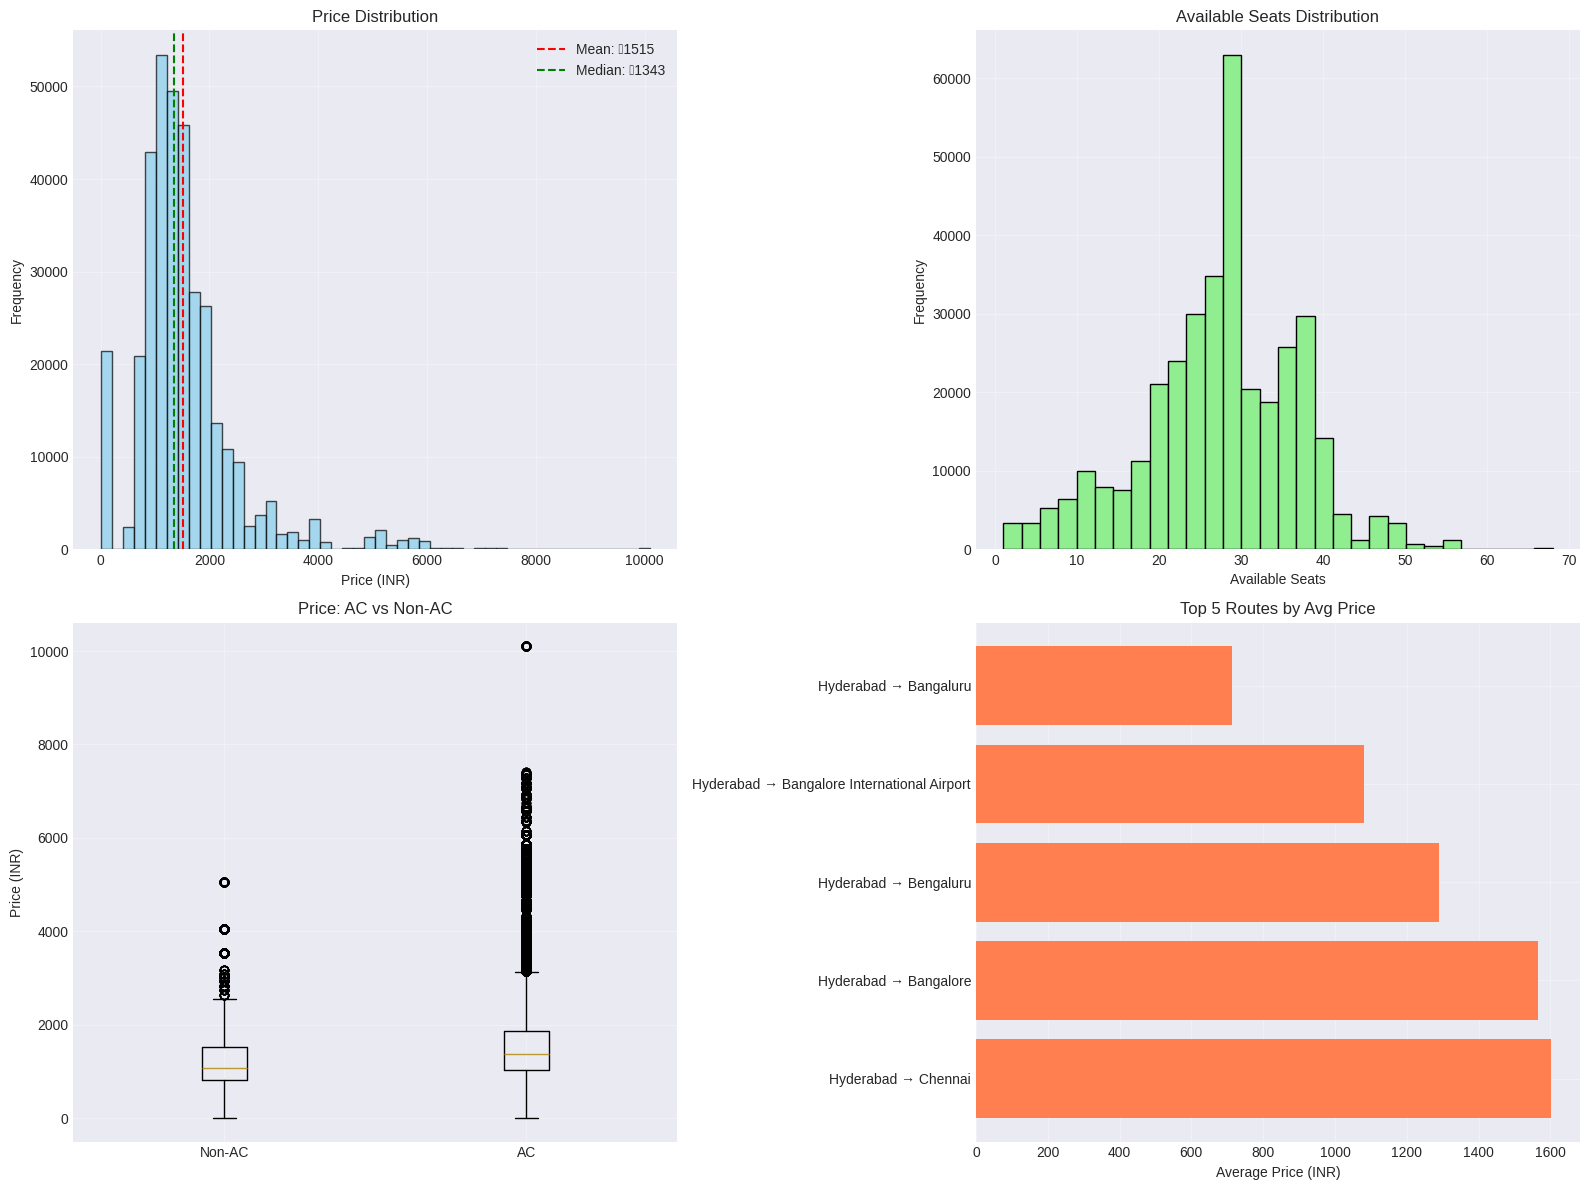

In [ ]:
import matplotlib.pyplot as plt
import logging
import pandas as pd
import wandb

class DataAnalyzer:
    """
    Comprehensive EDA with automatic fixes for common column issues.
    """

    def __init__(self, df):
        self.logger = logging.getLogger(self.__class__.__name__)
        self.df = df.copy()
        self.logger.info(f"DataAnalyzer initialized with {len(self.df):,} rows")

        # --- Fix / Create expected columns ---

        # Helper to safely get a single column Series, even if column name is duplicated
        def get_single_column_series(dataframe, col_name):
            if col_name in dataframe.columns:
                col_data = dataframe[col_name]
                if isinstance(col_data, pd.DataFrame):
                    # If multiple columns have the same name, pandas returns a DataFrame
                    # We'll take the first one.
                    self.logger.warning(f"Duplicate column '{col_name}' detected. Using the first occurrence.")
                    return col_data.iloc[:, 0]
                else:
                    return col_data
            return pd.Series(dtype='object') # Return empty series if not found

        source_series = get_single_column_series(self.df, 'source_name')
        destination_series = get_single_column_series(self.df, 'destination_name')

        # 1. Create 'route_name' if missing
        if 'route_name' not in self.df.columns:
            if not source_series.empty and not destination_series.empty:
                source_clean = source_series.astype(str).str.strip()
                dest_clean = destination_series.astype(str).str.strip()
                self.df['route_name'] = source_clean + " → " + dest_clean
                self.logger.info("Created 'route_name' from 'source_name' → 'destination_name'")
            else:
                missing_cols = []
                if source_series.empty: missing_cols.append('source_name')
                if destination_series.empty: missing_cols.append('destination_name')
                self.logger.error(f"Cannot create route_name: missing {missing_cols}")
                raise KeyError(f"Missing columns needed for route_name: {missing_cols}")
        else:
            self.logger.info("'route_name' already present")

        # 2. Ensure 'scrape_timestamp' exists
        if 'scrape_timestamp' not in self.df.columns:
            if 'scraped_time' in self.df.columns:
                self.df['scrape_timestamp'] = pd.to_datetime(self.df['scraped_time'], errors='coerce')
                self.logger.info("Created 'scrape_timestamp' from 'scraped_time'")
            else:
                self.logger.warning("No timestamp column found. Date range will be NaT.")
                self.df['scrape_timestamp'] = pd.NaT
        else:
            # Ensure it's datetime type if it exists but might not be correctly typed
            if not pd.api.types.is_datetime64_any_dtype(self.df['scrape_timestamp']):
                self.df['scrape_timestamp'] = pd.to_datetime(self.df['scrape_timestamp'], errors='coerce')
                self.logger.info("Ensured 'scrape_timestamp' is datetime type.")

        # 3. Ensure price is numeric
        if 'price' in self.df.columns:
            self.df['price'] = pd.to_numeric(self.df['price'], errors='coerce')

    def get_summary_statistics(self):
        summary = {
            'total_records': len(self.df),
            'unique_routes': self.df['route_name'].nunique() if 'route_name' in self.df.columns else 0,
            'unique_buses': self.df['bus_id'].nunique(),
            'unique_operators': self.df['operator_name'].nunique() if 'operator_name' in self.df.columns else 0,
            'date_range_start': self.df['scrape_timestamp'].min(),
            'date_range_end': self.df['scrape_timestamp'].max(),
            'price_stats': self.df['price'].describe().to_dict() if 'price' in self.df.columns else {},
            'missing_values': self.df.isnull().sum().to_dict()
        }
        return summary

    def plot_distributions(self):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Price distribution
        if 'price' in self.df.columns:
            price_data = self.df['price'].dropna()
            if len(price_data) > 0:
                axes[0, 0].hist(price_data, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
                mean_p = price_data.mean()
                median_p = price_data.median()
                axes[0, 0].axvline(mean_p, color='red', linestyle='--', label=f'Mean: ₹{mean_p:.0f}')
                axes[0, 0].axvline(median_p, color='green', linestyle='--', label=f'Median: ₹{median_p:.0f}')
                axes[0, 0].legend()
            else:
                axes[0, 0].text(0.5, 0.5, 'No valid price data', ha='center', va='center', transform=axes[0, 0].transAxes)
        else:
            axes[0, 0].text(0.5, 0.5, 'price column\nnot found', ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Price Distribution')
        axes[0, 0].set_xlabel('Price (INR)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].grid(True, alpha=0.3)

        # Available seats
        if 'available_seats' in self.df.columns:
            available_seats_data = self.df['available_seats'].dropna()
            if len(available_seats_data) > 0: # Add guard
                axes[0, 1].hist(available_seats_data, bins=30, color='lightgreen', edgecolor='black')
                axes[0, 1].set_title('Available Seats Distribution')
                axes[0, 1].set_xlabel('Available Seats')
            else: # Guard for empty series after dropna
                axes[0, 1].text(0.5, 0.5, 'available_seats\nno valid data', ha='center', va='center', transform=axes[0, 1].transAxes)
        else:
            axes[0, 1].text(0.5, 0.5, 'available_seats\nnot found', ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].grid(True, alpha=0.3)

        # AC vs Non-AC
        if 'is_AC' in self.df.columns and 'price' in self.df.columns:
            ac_prices = self.df[self.df['is_AC'] == True]['price'].dropna()
            non_ac_prices = self.df[self.df['is_AC'] == False]['price'].dropna()
            data_to_plot = []
            labels = []
            if len(non_ac_prices) > 0:
                data_to_plot.append(non_ac_prices)
                labels.append('Non-AC')
            if len(ac_prices) > 0:
                data_to_plot.append(ac_prices)
                labels.append('AC')

            if data_to_plot: # Only plot if there's data
                axes[1, 0].boxplot(data_to_plot, labels=labels)
                axes[1, 0].set_title('Price: AC vs Non-AC')
            else:
                axes[1, 0].text(0.5, 0.5, 'No AC/Non-AC price data', ha='center', va='center', transform=axes[1, 0].transAxes)
        else:
            axes[1, 0].text(0.5, 0.5, 'is_AC or price column\nmissing', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_ylabel('Price (INR)')
        axes[1, 0].grid(True, alpha=0.3)

        # Top routes by average price
        if 'route_name' in self.df.columns and 'price' in self.df.columns:
            max_display = 10
            route_avg = self.df.groupby('route_name')['price'].mean().sort_values(ascending=False).head(max_display)
            if len(route_avg) > 0:
                axes[1, 1].barh(range(len(route_avg)), route_avg.values, color='coral')
                axes[1, 1].set_yticks(range(len(route_avg)))
                axes[1, 1].set_yticklabels(route_avg.index)
                axes[1, 1].set_xlabel('Average Price (INR)')
                axes[1, 1].set_title(f'Top {len(route_avg)} Routes by Avg Price')
            else:
                axes[1, 1].text(0.5, 0.5, 'No price data for routes', ha='center', va='center', transform=axes[1, 1].transAxes)
        else:
            axes[1, 1].text(0.5, 0.5, 'route_name or price column\nmissing', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        wandb.log({"eda_distributions": wandb.Image(fig)})
        plt.show()
        plt.close(fig)

    def analyze(self):
        print("="*80)
        print("EXPLORATORY DATA ANALYSIS")
        print("="*80)

        summary = self.get_summary_statistics()

        print(f"\nDataset Overview:")
        print(f"  Total Records       : {summary['total_records']:,}")
        print(f"  Unique Routes       : {summary['unique_routes']:,}")
        print(f"  Unique Buses        : {summary['unique_buses']:,}")
        print(f"  Unique Operators    : {summary['unique_operators']:,}")
        print(f"  Scrape Date Range   : {summary['date_range_start']} → {summary['date_range_end']}")

        print(f"\nPrice Statistics:")
        for stat, val in summary['price_stats'].items():
            if pd.notna(val):
                print(f"  {stat.capitalize():<8}: ₹{val:,.2f}")

        print(f"\nMissing Values (Key Columns):")
        keys = ['price', 'route_name', 'journey_date', 'departure_time', 'available_seats', 'is_AC']
        any_missing = False
        for col in keys:
            if col in self.df.columns:
                miss = self.df[col].isnull().sum()
                if miss > 0:
                    pct = miss / len(self.df) * 100
                    print(f"  {col:<20}: {miss:,} ({pct:.1f}%)")
                    any_missing = True
        if not any_missing:
            print("  No critical missing values")

        wandb.log({
            "eda/total_records": summary['total_records'],
            "eda/unique_routes": summary['unique_routes'],
            "eda/price_mean": summary['price_stats'].get('mean'),
            "eda/price_median": summary['price_stats'].get('50%'),
        })

        print("\nGenerating visualizations...")
        self.plot_distributions()

        return summary


# =========================
# Run EDA
# =========================
print("Starting EDA...\n")
analyzer = DataAnalyzer(df_raw)
eda_summary = analyzer.analyze()

## Section 6: Data Preprocessing

DATA PREPROCESSING

Initial records: 351,878

Final records: 290,919
Data retention: 82.7%

Preprocessing Summary:
  Duplicates Removed: 20556
  Missing Critical Removed: 0
  Invalid Prices Removed: 19307
  Invalid Seats Removed: 0
  Outliers Removed: 21096


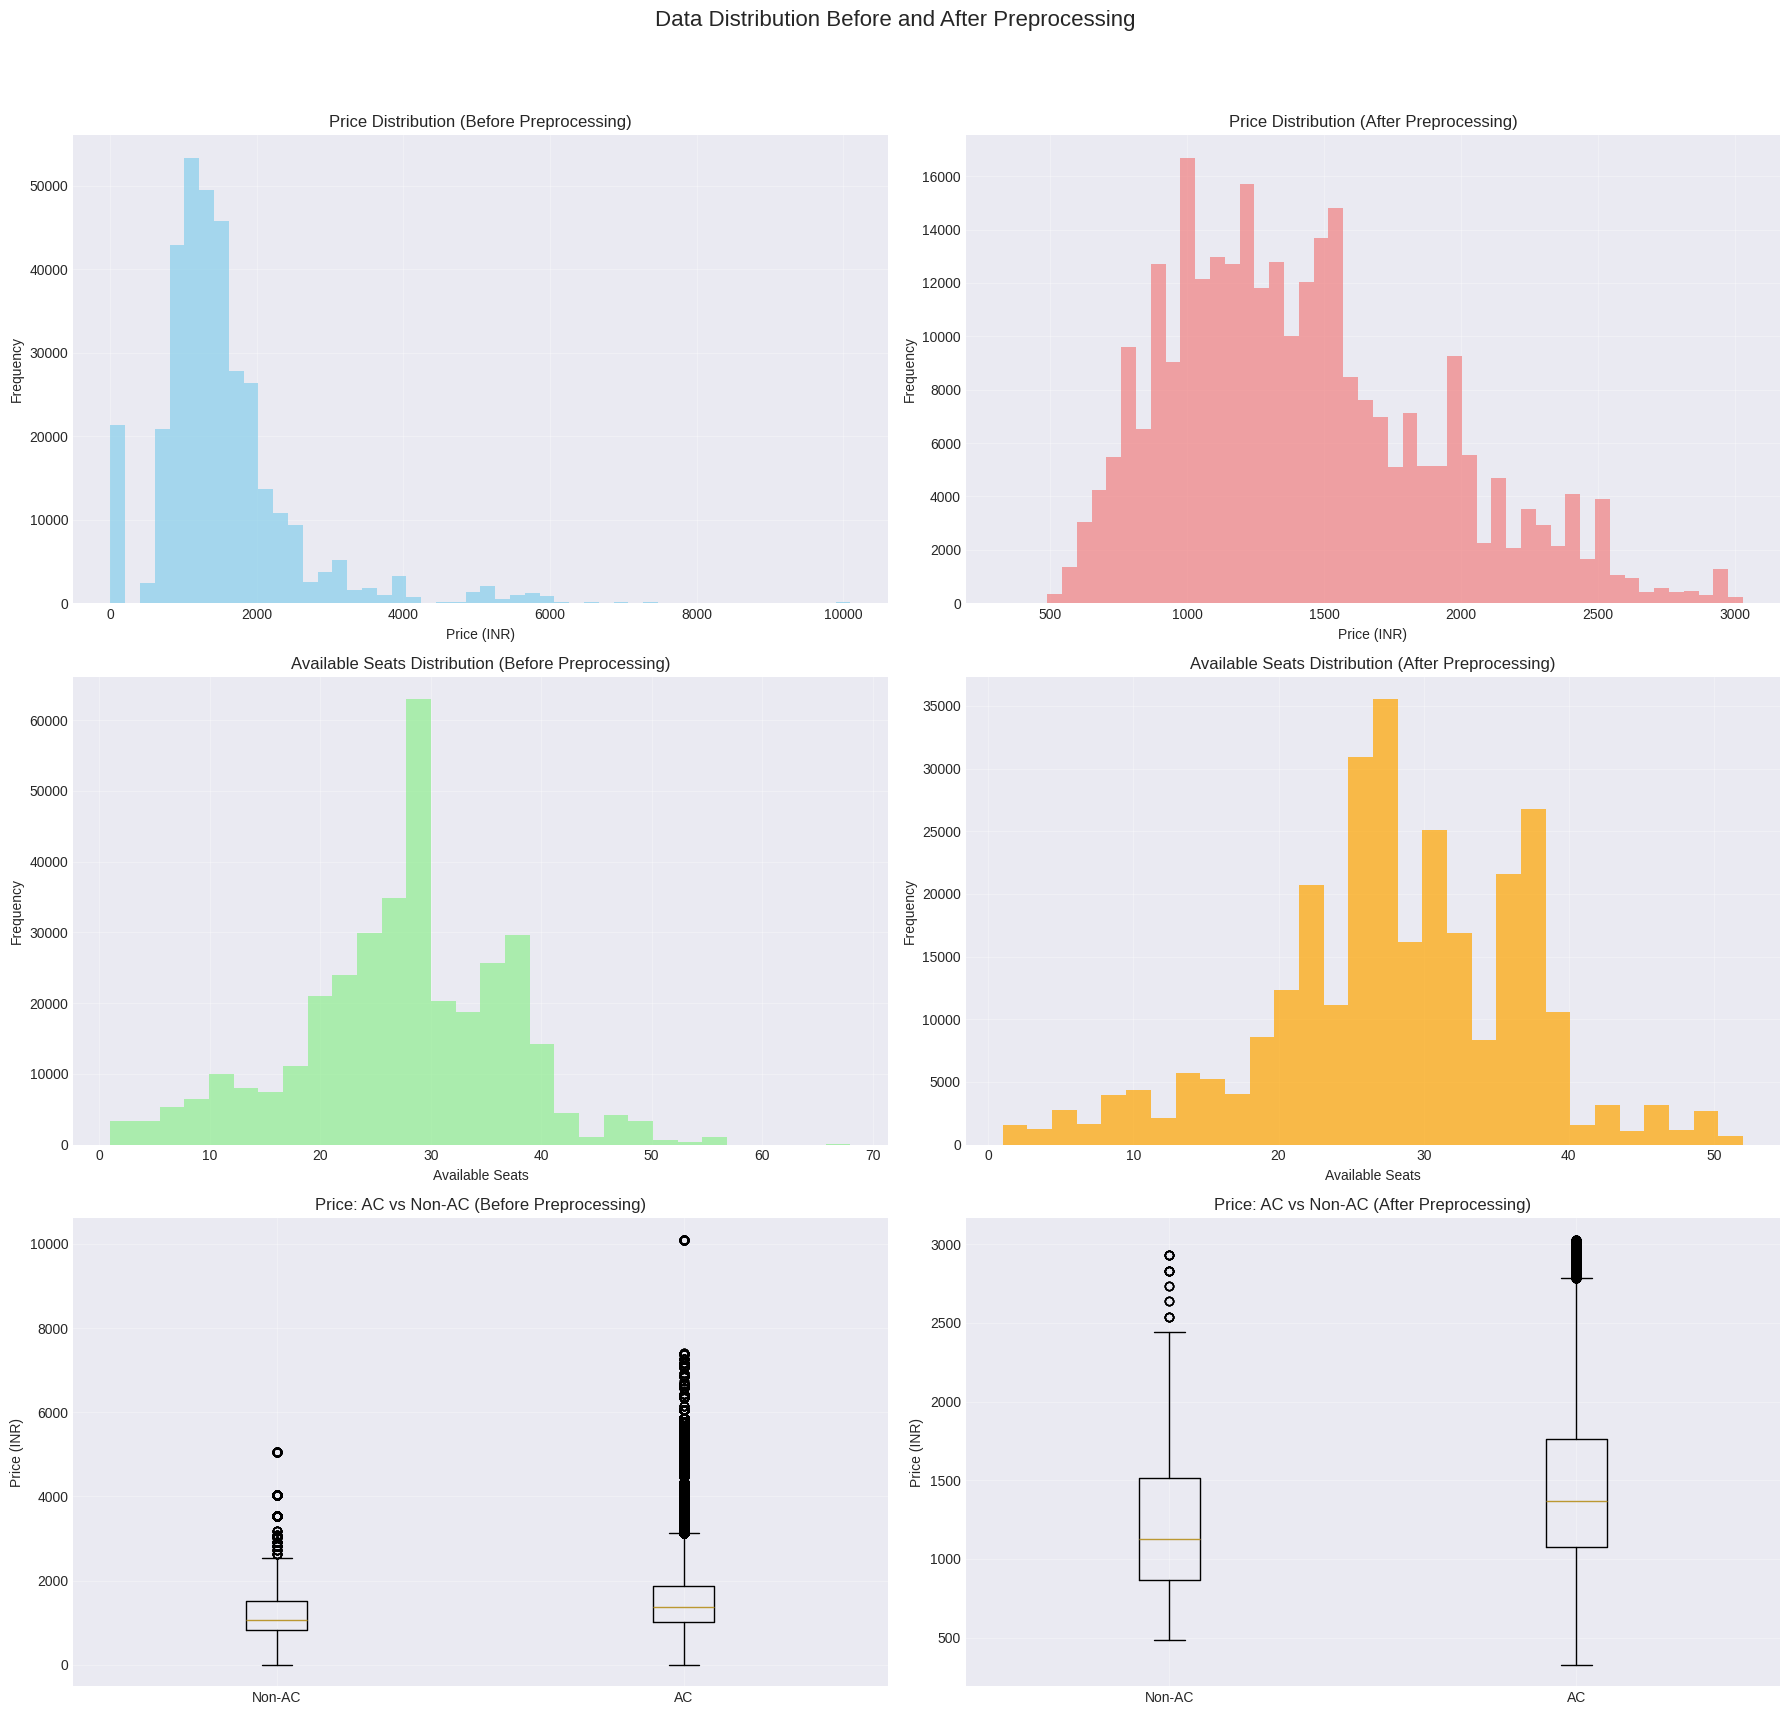


Cleaned Data Sample:


,route_name,operator_name,bus_type,available_seats,price
0,Hyderabad → Bangalore,Jabbar Travels,VE A/C Sleeper (2+1),6,1103.0
1,Hyderabad → Bangalore,Jabbar Travels,VE A/C Sleeper (2+1),6,1103.0
2,Hyderabad → Bangalore,Jabbar Travels,VE A/C Sleeper (2+1),6,1103.0
3,Hyderabad → Bangalore,Jabbar Travels,VE A/C Sleeper (2+1),6,1103.0
4,Hyderabad → Bangalore,Jabbar Travels,VE A/C Sleeper (2+1),6,1103.0


In [ ]:
class DataPreprocessor:
    """
    Professional data preprocessing with validation and logging.
    """

    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)
        self.preprocessing_stats = {}

    def remove_duplicates(self, df):
        """Remove duplicate records."""
        initial_count = len(df)
        df = df.drop_duplicates(
            subset=['route_name', 'journey_date', 'scrape_timestamp', 'bus_id','seat_name'],
            keep='first'
        )
        removed = initial_count - len(df)
        self.preprocessing_stats['duplicates_removed'] = removed
        self.logger.info(f"Removed {removed} duplicate records")
        return df

    def handle_missing_values(self, df):
        """Handle missing values with appropriate strategies."""
        initial_count = len(df)

        # Drop records with missing critical fields
        df = df.dropna(subset=['price', 'journey_date', 'scrape_timestamp'])

        removed = initial_count - len(df)
        self.preprocessing_stats['missing_critical_removed'] = removed
        self.logger.info(f"Removed {removed} records with missing critical values")

        return df

    def remove_invalid_prices(self, df, min_price=100, max_price=10000):
        """Remove records with invalid prices."""
        initial_count = len(df)
        df = df[(df['price'] >= min_price) & (df['price'] <= max_price)]
        removed = initial_count - len(df)
        self.preprocessing_stats['invalid_prices_removed'] = removed
        self.logger.info(f"Removed {removed} records with invalid prices")
        return df

    def remove_outliers(self, df, column='price', method='iqr'):
        """Remove outliers using IQR method."""
        initial_count = len(df)

        if method == 'iqr':
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

        removed = initial_count - len(df)
        self.preprocessing_stats['outliers_removed'] = removed
        self.logger.info(f"Removed {removed} outliers from {column}")

        return df

    def validate_seat_data(self, df):
        """Validate and clean seat-related data."""
        initial_count = len(df)

        # Remove records with negative seats
        df = df[df['available_seats'] >= 0]
        df = df[df['window_seats'] >= 0]

        # Ensure window seats <= available seats
        df = df[df['window_seats'] <= df['available_seats']]

        removed = initial_count - len(df)
        self.preprocessing_stats['invalid_seats_removed'] = removed
        self.logger.info(f"Removed {removed} records with invalid seat data")

        return df

    def plot_distributions_before_after(self, df_initial, df_cleaned):
        """
        Generates plots to show the difference in data distributions
        before and after preprocessing.
        """
        self.logger.info("Generating before/after preprocessing distribution plots...")

        fig, axes = plt.subplots(3, 2, figsize=(18, 18)) # Increased rows to 3
        fig.suptitle('Data Distribution Before and After Preprocessing', fontsize=16)

        # Price Distribution
        if 'price' in df_initial.columns and 'price' in df_cleaned.columns:
            axes[0, 0].hist(df_initial['price'].dropna(), bins=50, color='skyblue', alpha=0.7, label='Before Prep.')
            axes[0, 0].set_title('Price Distribution (Before Preprocessing)')
            axes[0, 0].set_xlabel('Price (INR)')
            axes[0, 0].set_ylabel('Frequency')
            axes[0, 0].grid(True, alpha=0.3)

            axes[0, 1].hist(df_cleaned['price'].dropna(), bins=50, color='lightcoral', alpha=0.7, label='After Prep.')
            axes[0, 1].set_title('Price Distribution (After Preprocessing)')
            axes[0, 1].set_xlabel('Price (INR)')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 0].text(0.5, 0.5, 'Price column not available', ha='center', va='center', transform=axes[0, 0].transAxes)
            axes[0, 1].text(0.5, 0.5, 'Price column not available', ha='center', va='center', transform=axes[0, 1].transAxes)

        # Available Seats Distribution
        if 'available_seats' in df_initial.columns and 'available_seats' in df_cleaned.columns:
            axes[1, 0].hist(df_initial['available_seats'].dropna(), bins=30, color='lightgreen', alpha=0.7, label='Before Prep.')
            axes[1, 0].set_title('Available Seats Distribution (Before Preprocessing)')
            axes[1, 0].set_xlabel('Available Seats')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].grid(True, alpha=0.3)

            axes[1, 1].hist(df_cleaned['available_seats'].dropna(), bins=30, color='orange', alpha=0.7, label='After Prep.')
            axes[1, 1].set_title('Available Seats Distribution (After Preprocessing)')
            axes[1, 1].set_xlabel('Available Seats')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'Available seats column not available', ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 1].text(0.5, 0.5, 'Available seats column not available', ha='center', va='center', transform=axes[1, 1].transAxes)

        # Price AC vs Non-AC Boxplot (Before Preprocessing)
        if 'is_AC' in df_initial.columns and 'price' in df_initial.columns:
            ac_prices_initial = df_initial[df_initial['is_AC'] == True]['price'].dropna()
            non_ac_prices_initial = df_initial[df_initial['is_AC'] == False]['price'].dropna()
            data_to_plot_initial = []
            labels_initial = []
            if len(non_ac_prices_initial) > 0:
                data_to_plot_initial.append(non_ac_prices_initial)
                labels_initial.append('Non-AC')
            if len(ac_prices_initial) > 0:
                data_to_plot_initial.append(ac_prices_initial)
                labels_initial.append('AC')

            if data_to_plot_initial:
                axes[2, 0].boxplot(data_to_plot_initial, labels=labels_initial)
                axes[2, 0].set_title('Price: AC vs Non-AC (Before Preprocessing)')
                axes[2, 0].set_ylabel('Price (INR)')
                axes[2, 0].grid(True, alpha=0.3)
            else:
                axes[2, 0].text(0.5, 0.5, 'No AC/Non-AC price data (Before)', ha='center', va='center', transform=axes[2, 0].transAxes)
        else:
            axes[2, 0].text(0.5, 0.5, 'is_AC or price column missing (Before)', ha='center', va='center', transform=axes[2, 0].transAxes)

        # Price AC vs Non-AC Boxplot (After Preprocessing)
        if 'is_AC' in df_cleaned.columns and 'price' in df_cleaned.columns:
            ac_prices_cleaned = df_cleaned[df_cleaned['is_AC'] == True]['price'].dropna()
            non_ac_prices_cleaned = df_cleaned[df_cleaned['is_AC'] == False]['price'].dropna()
            data_to_plot_cleaned = []
            labels_cleaned = []
            if len(non_ac_prices_cleaned) > 0:
                data_to_plot_cleaned.append(non_ac_prices_cleaned)
                labels_cleaned.append('Non-AC')
            if len(ac_prices_cleaned) > 0:
                data_to_plot_cleaned.append(ac_prices_cleaned)
                labels_cleaned.append('AC')

            if data_to_plot_cleaned:
                axes[2, 1].boxplot(data_to_plot_cleaned, labels=labels_cleaned)
                axes[2, 1].set_title('Price: AC vs Non-AC (After Preprocessing)')
                axes[2, 1].set_ylabel('Price (INR)')
                axes[2, 1].grid(True, alpha=0.3)
            else:
                axes[2, 1].text(0.5, 0.5, 'No AC/Non-AC price data (After)', ha='center', va='center', transform=axes[2, 1].transAxes)
        else:
            axes[2, 1].text(0.5, 0.5, 'is_AC or price column missing (After)', ha='center', va='center', transform=axes[2, 1].transAxes)


        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        wandb.log({"preprocessing_distributions": wandb.Image(fig)})
        plt.show()
        plt.close(fig)


    def preprocess(self, df):
        """
        Execute complete preprocessing pipeline.
        """
        print("="*80)
        print("DATA PREPROCESSING")
        print("="*80)

        initial_count = len(df)
        print(f"\nInitial records: {initial_count:,}")

        df_initial = df.copy() # Keep a copy of the initial DataFrame for comparison

        # Step 1: Remove duplicates
        df = self.remove_duplicates(df)

        # Step 2: Handle missing values
        df = self.handle_missing_values(df)

        # Step 3: Remove invalid prices
        df = self.remove_invalid_prices(df)

        # Step 4: Validate seat data
        df = self.validate_seat_data(df)

        # Step 5: Remove outliers
        df = self.remove_outliers(df)

        final_count = len(df)
        retention_rate = (final_count / initial_count) * 100

        self.preprocessing_stats['initial_records'] = initial_count
        self.preprocessing_stats['final_records'] = final_count
        self.preprocessing_stats['retention_rate'] = retention_rate

        print(f"\nFinal records: {final_count:,}")
        print(f"Data retention: {retention_rate:.1f}%")
        print(f"\nPreprocessing Summary:")
        for key, value in self.preprocessing_stats.items():
            if 'removed' in key:
                print(f"  {key.replace('_', ' ').title()}: {value}")

        # Log to W&B
        wandb.log(self.preprocessing_stats)

        # Generate before/after plots
        self.plot_distributions_before_after(df_initial, df)

        return df

# Run preprocessing
preprocessor = DataPreprocessor()
df_clean = preprocessor.preprocess(analyzer.df.copy()) # Changed df_raw.copy() to analyzer.df.copy()

print("\nCleaned Data Sample:")
df_clean[['route_name', 'operator_name', 'bus_type', 'available_seats', 'price']].head()

## Section 7: Feature Engineering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

class SeatPriceFeatureEngineer:
    """
    Feature engineering for seat-level bus dynamic pricing prediction.
    Designed for your current cleaned dataframe (df_clean).
    """

    def __init__(self):
        self.label_encoders = {}
        self.feature_columns = []

    def extract_temporal_features(self, df):
        """Extract rich time-based features."""
        df = df.copy()

        # Ensure datetime columns are converted to datetime objects and then localized to be naive.
        # This resolves the "Cannot mix tz-aware with tz-naive values" error.
        for col in ['journey_date', 'departure_time', 'scrape_timestamp']:
            if col in df.columns:
                # Convert to datetime, coercing errors will turn invalid parses into NaT
                df[col] = pd.to_datetime(df[col], errors='coerce')
                # If timezone information exists, remove it to make consistent (timezone-naive)
                if pd.api.types.is_datetime64_any_dtype(df[col]) and df[col].dt.tz is not None:
                    df[col] = df[col].dt.tz_localize(None)

        # Now all relevant datetime columns are timezone-naive datetime objects.
        # Proceed with feature extraction.

        # Journey features
        df['journey_day_of_week'] = df['journey_date'].dt.dayofweek  # 0=Mon
        df['journey_is_weekend'] = df['journey_day_of_week'].isin([5, 6]).astype(int)
        df['journey_month'] = df['journey_date'].dt.month
        df['journey_day'] = df['journey_date'].dt.day

        # Departure time features
        df['departure_hour'] = df['departure_time'].dt.hour
        df['departure_hour_bin'] = pd.cut(df['departure_hour'],
                                          bins=[0, 6, 12, 18, 24],
                                          labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                          include_lowest=True)

        # Advance booking days (how many days before journey was this scraped)
        # Both are now timezone-naive datetime objects. Using .dt.date on both for subtraction.
        df['days_to_journey'] = (df['journey_date'].dt.date - df['scrape_timestamp'].dt.date).dt.days
        df['days_to_journey'] = df['days_to_journey'].clip(lower=0)  # no negative

        # Booking urgency
        df['is_last_minute'] = (df['days_to_journey'] <= 1).astype(int)
        df['is_early_booking'] = (df['days_to_journey'] >= 15).astype(int)

        return df

    def extract_route_features(self, df):
        """Route popularity and competition features."""
        # Route popularity (how many buses on this route in data)
        route_counts = df['route_name'].value_counts()
        df['route_popularity'] = df['route_name'].map(route_counts)

        # Number of operators on route
        route_operator_count = df.groupby('route_name')['operator_name'].nunique()
        df['route_competition_level'] = df['route_name'].map(route_operator_count)

        # Average price per route (target encoding - careful with leakage if not CV)
        route_avg_price = df.groupby('route_name')['price'].mean()
        df['route_avg_price'] = df['route_name'].map(route_avg_price)

        return df

    def extract_bus_and_operator_features(self, df):
        """Bus and operator level features."""
        # Operator reputation proxy: average price and count
        operator_stats = df.groupby('operator_name')['price'].agg(['mean', 'count'])
        operator_stats.rename(columns={'mean': 'operator_avg_price', 'count': 'operator_bus_count'}, inplace=True)
        df = df.merge(operator_stats, on='operator_name', how='left')

        # Bus type encoding
        df['is_sleeper'] = df['bus_type'].str.contains('sleeper', case=False, na=False).astype(int)
        df['is_volvo_or_ac'] = ((df['bus_type'].str.contains('volvo', case=False, na=False)) |
                                (df['is_AC'] == True)).astype(int)

        return df

    def extract_seat_features(self, df):
        """Seat-specific features."""
        # Seat position encoding
        df['is_window_seat'] = df['window_seats'].apply(lambda x: 1 if x > 0 else 0)  # simplified
        df['is_lower_berth'] = (~df['seat_is_upper']).astype(int)
        df['is_ladies_seat'] = df['seat_is_ladiesSeat'].astype(int)

        # Seat availability ratio (proxy for demand)
        df['seat_availability_ratio'] = df['available_seats'] / 40  # assuming ~40 seats avg
        df['seat_availability_ratio'] = df['seat_availability_ratio'].clip(0, 1)

        # High demand indicator
        df['high_demand'] = (df['available_seats'] <= 10).astype(int)

        return df

    def encode_categorical(self, df):
        """Label encode high-cardinality categoricals safely."""
        high_card_cols = ['route_name', 'operator_name', 'bus_id', 'seat_name', 'bus_type']

        for col in high_card_cols:
            if col in df.columns:
                le = LabelEncoder()
                df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
                self.label_encoders[col] = le

        # One-hot for low cardinality
        if 'departure_hour_bin' in df.columns:
            df = pd.get_dummies(df, columns=['departure_hour_bin'], prefix='dep_time')

        return df

    def create_features(self, df):
        """Full feature engineering pipeline."""
        print("="*80)
        print("FEATURE ENGINEERING FOR SEAT-LEVEL PRICE PREDICTION")
        print("="*80)

        df_fe = df.copy()
        initial_cols = len(df_fe.columns)

        print(f"Starting with {len(df_fe):,} records and {initial_cols} columns...")

        df_fe = self.extract_temporal_features(df_fe)
        df_fe = self.extract_route_features(df_fe)
        df_fe = self.extract_bus_and_operator_features(df_fe)
        df_fe = self.extract_seat_features(df_fe)
        df_fe = self.encode_categorical(df_fe)

        # Final feature list (exclude target and raw IDs/strings)
        exclude_cols = ['price', 'scraped_time', 'source_name', 'destination_name',
                        'journey_date', 'departure_time', 'arrival_time', 'scrape_timestamp',
                        'route_name', 'operator_name', 'bus_id', 'seat_name', 'bus_type']

        self.feature_columns = [col for col in df_fe.columns if col not in exclude_cols]

        print(f"Feature engineering complete!")
        print(f"  → Created {len(self.feature_columns)} new features")
        print(f"  → Total columns now: {len(df_fe.columns)}")
        print(f"  → Ready for modeling")

        # Optional: log feature importance proxy
        wandb.log({
            "fe/num_features": len(self.feature_columns),
            "fe/total_columns": len(df_fe.columns),
            "fe/sample_features": self.feature_columns[:10]
        })

        return df_fe

    def get_features(self):
        """Return list of engineered feature names."""
        return self.feature_columns


# =========================
# Run Feature Engineering
# =========================
fe = SeatPriceFeatureEngineer()
df_features = fe.create_features(df_clean)

print("\nSample of Engineered Data:")
display_cols = ['route_name', 'seat_name', 'price', 'departure_hour', 'days_to_journey',
                'route_popularity', 'high_demand', 'is_lower_berth', 'operator_avg_price',
                'route_name_encoded']

print(df_features[display_cols].head(10))

print("\nTop 15 Engineered Features:")
print(fe.get_features()[:15])

FEATURE ENGINEERING FOR SEAT-LEVEL PRICE PREDICTION
Starting with 290,919 records and 21 columns...


ValueError: Cannot mix tz-aware with tz-naive values, at position 1

## Section 8: Categorical Encoding

In [ ]:
class CategoricalEncoder:
    """
    Handle categorical variable encoding with label encoders.
    """

    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)
        self.encoders = {}

    def encode_features(self, df):
        """
        Encode categorical features using Label Encoding.
        """
        print("="*80)
        print("CATEGORICAL ENCODING")
        print("="*80)

        categorical_cols = [
            'route_name',
            'source',
            'destination',
            'bus_type',
            'time_of_day',
            'seat_availability_category'
        ]

        print("\nEncoding categorical features:")

        for col in categorical_cols:
            if col in df.columns:
                # Convert to string first to avoid categorical dtype issues
                df[col] = df[col].astype(str).fillna('Unknown')

                # Create and fit label encoder
                le = LabelEncoder()
                df[f'{col}_encoded'] = le.fit_transform(df[col])
                self.encoders[col] = le

                print(f"  {col}: {len(le.classes_)} unique values")

                # Log class distribution for small cardinality features
                if len(le.classes_) <= 10:
                    value_counts = df[col].value_counts()
                    print(f"    Distribution: {dict(value_counts.head(5))}")

        print(f"\nTotal encoders created: {len(self.encoders)}")

        # Log to W&B
        wandb.log({
            'num_categorical_features': len(self.encoders),
            'total_categorical_classes': sum(len(enc.classes_) for enc in self.encoders.values())
        })

        return df

# Run encoding
encoder = CategoricalEncoder()
df_encoded = encoder.encode_features(df_features.copy())

print("\nEncoded DataFrame Info:")
print(f"  Total columns: {len(df_encoded.columns)}")
print(f"  Encoded columns: {[col for col in df_encoded.columns if '_encoded' in col]}")

print("\nSample of encoded data:")
display_cols = ['route_name', 'route_name_encoded', 'bus_type', 'bus_type_encoded',
                'time_of_day', 'time_of_day_encoded', 'price']
df_encoded[display_cols].head(10)

## Section 9: Train-Test Split

In [ ]:
# Define feature columns
numerical_features = [
    'days_to_departure',
    'hours_to_departure',
    'departure_hour',
    'departure_day_of_week',
    'departure_month',
    'is_weekend',
    'is_holiday',
    'available_seats',
    'window_seats',
    'seat_fill_percentage',
    'occupancy_rate',
    'window_seat_ratio',
    'route_popularity',
    'route_avg_price',
    'route_median_price',
    'price_vs_route_avg',
    'price_vs_route_avg_pct',
    'price_change',
    'price_velocity',
    'is_AC_int',
    'num_boarding_points',
    'num_dropping_points'
]

encoded_features = [f"{col}_encoded" for col in encoder.encoders.keys()]

all_features = numerical_features + encoded_features

# Filter features that exist in dataframe
available_features = [f for f in all_features if f in df_encoded.columns]

print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"\nTotal features for training: {len(available_features)}")
print(f"  Numerical: {len([f for f in available_features if f in numerical_features])}")
print(f"  Encoded: {len([f for f in available_features if f in encoded_features])}")

# Prepare data
X = df_encoded[available_features]
y = df_encoded['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=config.test_size,
    random_state=config.random_state,
    shuffle=True
)

print(f"\nData Split:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Testing samples: {len(X_test):,}")
print(f"  Split ratio: {len(X_train)/len(X_test):.2f}:1")

# Log to W&B
wandb.log({
    'total_features': len(available_features),
    'train_samples': len(X_train),
    'test_samples': len(X_test)
})

## Section 10: Model Training

In [ ]:
class ModelTrainer:
    """
    Train multiple ML models with W&B tracking.
    """

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.models = {}
        self.results = {}
        self.logger = logging.getLogger(self.__class__.__name__)

    def train_linear_regression(self):
        """Train Linear Regression model."""
        self.logger.info("Training Linear Regression...")
        model = LinearRegression()
        model.fit(self.X_train, self.y_train)
        self.models['LinearRegression'] = model
        return model

    def train_random_forest(self):
        """Train Random Forest model."""
        self.logger.info("Training Random Forest...")
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=0
        )
        model.fit(self.X_train, self.y_train)
        self.models['RandomForest'] = model
        return model

    def train_xgboost(self):
        """Train XGBoost model."""
        self.logger.info("Training XGBoost...")
        model = xgb.XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=0
        )
        model.fit(self.X_train, self.y_train)
        self.models['XGBoost'] = model
        return model

    def train_gradient_boosting(self):
        """Train Gradient Boosting model."""
        self.logger.info("Training Gradient Boosting...")
        model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=RANDOM_STATE,
            verbose=0
        )
        model.fit(self.X_train, self.y_train)
        self.models['GradientBoosting'] = model
        return model

    def evaluate_model(self, model_name, model):
        """Evaluate model performance."""
        y_pred = model.predict(self.X_test)

        metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred)),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred),
            'mape': mean_absolute_percentage_error(self.y_test, y_pred) * 100
        }

        self.results[model_name] = {
            'model': model,
            'metrics': metrics,
            'predictions': y_pred
        }

        # Log to W&B
        wandb.log({
            f"{model_name}/rmse": metrics['rmse'],
            f"{model_name}/mae": metrics['mae'],
            f"{model_name}/r2": metrics['r2'],
            f"{model_name}/mape": metrics['mape']
        })

        return metrics

    def train_all(self):
        """
        Train all models and evaluate.
        """
        print("="*80)
        print("MODEL TRAINING")
        print("="*80)

        # Train models
        # self.train_linear_regression()
        self.train_random_forest()
        self.train_xgboost()
        self.train_gradient_boosting()

        print("\nEvaluating models...\n")
        print(f"{'Model':<25} {'RMSE':<12} {'MAE':<12} {'R²':<10} {'MAPE (%)':<10}")
        print("="*80)

        # Evaluate each model
        for name, model in self.models.items():
            metrics = self.evaluate_model(name, model)
            print(f"{name:<25} {metrics['rmse']:<12.2f} {metrics['mae']:<12.2f} "
                  f"{metrics['r2']:<10.4f} {metrics['mape']:<10.2f}")

        # Select best model
        best_model_name = max(self.results, key=lambda k: self.results[k]['metrics']['r2'])
        best_metrics = self.results[best_model_name]['metrics']

        print("\n" + "="*80)
        print(f"BEST MODEL: {best_model_name}")
        print("="*80)
        print(f"  R² Score: {best_metrics['r2']:.4f}")
        print(f"  RMSE: {best_metrics['rmse']:.2f} INR")
        print(f"  MAE: {best_metrics['mae']:.2f} INR")
        print(f"  MAPE: {best_metrics['mape']:.2f}%")

        # Log best model to W&B
        wandb.log({
            'best_model': best_model_name,
            'best_r2': best_metrics['r2'],
            'best_rmse': best_metrics['rmse'],
            'best_mae': best_metrics['mae'],
            'best_mape': best_metrics['mape']
        })

        return best_model_name

# Train all models
trainer = ModelTrainer(X_train, X_test, y_train, y_test)
best_model_name = trainer.train_all()

## Section 11: Model Evaluation & Visualization

In [ ]:
# Get best model results
best_result = trainer.results[best_model_name]
y_pred = best_result['predictions']

# Create evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred, alpha=0.5, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
               'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price (INR)', fontsize=12)
axes[0, 0].set_ylabel('Predicted Price (INR)', fontsize=12)
axes[0, 0].set_title(f'Actual vs Predicted - {best_model_name}', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual plot
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price (INR)', fontsize=12)
axes[0, 1].set_ylabel('Residuals (INR)', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Prediction Error (INR)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Model comparison
model_names = list(trainer.results.keys())
r2_scores = [trainer.results[m]['metrics']['r2'] for m in model_names]
colors = ['red' if m == best_model_name else 'steelblue' for m in model_names]

axes[1, 1].barh(model_names, r2_scores, color=colors)
axes[1, 1].set_xlabel('R² Score', fontsize=12)
axes[1, 1].set_title('Model Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

for i, (name, score) in enumerate(zip(model_names, r2_scores)):
    axes[1, 1].text(score + 0.01, i, f'{score:.4f}', va='center', fontsize=10)

plt.tight_layout()

# Log to W&B
wandb.log({"model_evaluation": wandb.Image(fig)})
plt.show()
plt.close()

## Section 12: Feature Importance Analysis

In [ ]:
best_model = best_result['model']

if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': available_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    print("\nTop 15 Most Important Features:\n")

    for idx, row in feature_importance.head(15).iterrows():
        print(f"  {row['feature']:<40} {row['importance']:.4f}")

    # Visualization
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()

    # Log to W&B
    wandb.log({"feature_importance": wandb.Image(plt)})
    plt.show()
    plt.close()

    # Log feature importance table to W&B
    wandb.log({"feature_importance_table": wandb.Table(dataframe=feature_importance.head(20))})

else:
    print("Feature importance not available for this model type.")

## Section 13: Model Persistence

In [ ]:
# Save model artifacts
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("="*80)
print("MODEL PERSISTENCE")
print("="*80)

# Save best model
model_filename = f'bus_price_model_{best_model_name}_{timestamp}.pkl'
joblib.dump(best_model, model_filename)
print(f"\nSaved model: {model_filename}")

# Save encoders
encoders_filename = f'label_encoders_{timestamp}.pkl'
with open(encoders_filename, 'wb') as f:
    pickle.dump(encoder.encoders, f)
print(f"Saved encoders: {encoders_filename}")

# Save feature names
features_filename = f'feature_names_{timestamp}.json'
with open(features_filename, 'w') as f:
    json.dump(available_features, f, indent=2)
print(f"Saved feature names: {features_filename}")

# Save metrics
metrics_filename = f'model_metrics_{timestamp}.json'
metrics_data = {
    'model_name': best_model_name,
    'timestamp': timestamp,
    'metrics': best_result['metrics'],
    'training_samples': len(X_train),
    'testing_samples': len(X_test),
    'num_features': len(available_features)
}
with open(metrics_filename, 'w') as f:
    json.dump(metrics_data, f, indent=2, default=str)
print(f"Saved metrics: {metrics_filename}")

# Save preprocessing stats
preprocessing_filename = f'preprocessing_stats_{timestamp}.json'
with open(preprocessing_filename, 'w') as f:
    json.dump(preprocessor.preprocessing_stats, f, indent=2, default=str)
print(f"Saved preprocessing stats: {preprocessing_filename}")

# Log artifacts to W&B
artifact = wandb.Artifact(
    name=f"bus-price-model-{timestamp}",
    type="model",
    description=f"Best model: {best_model_name} with R²={best_result['metrics']['r2']:.4f}"
)
artifact.add_file(model_filename)
artifact.add_file(encoders_filename)
artifact.add_file(features_filename)
artifact.add_file(metrics_filename)
wandb.log_artifact(artifact)

print(f"\nArtifacts logged to W&B")

# Download files
print("\nDownloading files...")
files.download(model_filename)
files.download(encoders_filename)
files.download(features_filename)
files.download(metrics_filename)
files.download(preprocessing_filename)

print("\nAll files downloaded successfully.")

## Section 14: Sample Predictions

In [ ]:
print("="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Select random samples
num_samples = min(10, len(X_test))
sample_indices = np.random.choice(len(X_test), size=num_samples, replace=False)
X_sample = X_test.iloc[sample_indices]
y_actual = y_test.iloc[sample_indices]

# Predict
y_pred_sample = best_model.predict(X_sample)

# Display results
print(f"\n{'Actual Price':<15} {'Predicted':<15} {'Error':<15} {'Error %':<10}")
print("="*80)

for actual, predicted in zip(y_actual, y_pred_sample):
    error = predicted - actual
    error_pct = (abs(error) / actual) * 100
    print(f"{actual:<15.2f} {predicted:<15.2f} {error:<15.2f} {error_pct:<10.1f}")

avg_error = np.mean(np.abs(y_pred_sample - y_actual))
print(f"\nAverage Absolute Error: {avg_error:.2f} INR")

## Section 15: Final Summary & W&B Dashboard

In [ ]:
print("\n" + "="*80)
print("PIPELINE EXECUTION COMPLETE")
print("="*80)

final_summary = {
    'total_records_processed': len(df_raw),
    'final_records_used': len(df_encoded),
    'retention_rate': (len(df_encoded) / len(df_raw)) * 100,
    'total_features': len(available_features),
    'best_model': best_model_name,
    'r2_score': best_result['metrics']['r2'],
    'rmse': best_result['metrics']['rmse'],
    'mae': best_result['metrics']['mae'],
    'mape': best_result['metrics']['mape']
}

print("\nExecution Summary:")
print(f"  Total Records Processed: {final_summary['total_records_processed']:,}")
print(f"  Records Used for Training: {final_summary['final_records_used']:,}")
print(f"  Data Retention Rate: {final_summary['retention_rate']:.1f}%")
print(f"  Total Features: {final_summary['total_features']}")
print(f"\nBest Model: {final_summary['best_model']}")
print(f"  R² Score: {final_summary['r2_score']:.4f} ({final_summary['r2_score']*100:.1f}% variance explained)")
print(f"  RMSE: {final_summary['rmse']:.2f} INR")
print(f"  MAE: {final_summary['mae']:.2f} INR")
print(f"  MAPE: {final_summary['mape']:.2f}%")

# Interpretation
print("\nModel Performance Interpretation:")
if final_summary['r2_score'] >= 0.85:
    print("  Status: EXCELLENT - Production ready")
elif final_summary['r2_score'] >= 0.75:
    print("  Status: GOOD - Can be improved with more data")
elif final_summary['r2_score'] >= 0.65:
    print("  Status: FAIR - Needs more data for better accuracy")
else:
    print("  Status: NEEDS IMPROVEMENT - Collect more data")

print(f"\nRecommendations:")
if len(df_encoded) < 1000:
    print(f"  Current data: {len(df_encoded)} records")
    print("  Target: 10,000+ records")
    print("  Action: Continue hourly scraping for 1-2 weeks")
elif len(df_encoded) < 10000:
    print(f"  Current data: {len(df_encoded)} records")
    print("  Status: Good progress")
    print("  Action: Keep collecting to reach 10,000+ records")
else:
    print(f"  Current data: {len(df_encoded)} records")
    print("  Status: Excellent data volume")
    print("  Action: Ready for production deployment")

print(f"\nWeights & Biases Dashboard:")
print(f"  Run Name: {run.name}")
print(f"  Dashboard URL: {run.url}")
print("  View your training metrics, visualizations, and artifacts in W&B")

# Log final summary
wandb.log(final_summary)

# Finish W&B run
wandb.finish()

print("\n" + "="*80)
print("Thank you for using the Bus Price Prediction Pipeline")
print("="*80)

---

## Usage Instructions

### Loading the Saved Model

```python
import joblib
import pickle
import pandas as pd

# Load model
model = joblib.load('bus_price_model_XGBoost_TIMESTAMP.pkl')

# Load encoders
with open('label_encoders_TIMESTAMP.pkl', 'rb') as f:
    encoders = pickle.load(f)

# Load feature names
with open('feature_names_TIMESTAMP.json', 'r') as f:
    feature_names = json.load(f)

# Prepare input data with all required features
input_data = {...}  # Your feature dictionary

# Make prediction
input_df = pd.DataFrame([input_data])[feature_names]
predicted_price = model.predict(input_df)[0]
```

### Next Steps

1. Monitor training runs in W&B dashboard
2. Collect more data to improve accuracy
3. Retrain model periodically
4. Deploy model via API endpoint
5. Set up automated retraining pipeline

---